<a href="https://colab.research.google.com/github/Eric-rWang/VivoX/blob/main/PPG_VivoX_v1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import h5py

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim

os.chdir("/content/PPG ML")
print(os.getcwd())

/content/PPG ML


VivoX transformer model:
<ul>
<li>Linear projection from flattened window inputs to d_model</li>
<li>Sinusoidal positional encodings</li>
<li>Standard encoder stack</li>
<li>Mean pooling and MLP head for arterial and venous regression</li>
</ul>

In [5]:
class PositionalEncoding(nn.Module):
    """
    Implements sinusoidal positional encoding.
    """
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor of shape (batch_size, seq_len, d_model)
        Returns:
            Tensor: (batch_size, seq_len, d_model) with positional encoding added
        """
        x = x + self.pe[:, :x.size(1), :]
        return x


class vivoxTransformer(nn.Module):
    """
    Simple Transformer model for arterial & venous SpO2 prediction from multichannel PPG.

    Args:
        num_channels: number of input channels (e.g., 36)
        window_size: number of time samples per window (e.g., 350)
        d_model: embedding dimension
        nhead: number of attention heads
        num_layers: number of Transformer encoder layers
        dim_feedforward: dimension of the MLP in encoder layers
        dropout: dropout rate
    """
    def __init__(
        self,
        num_channels: int = 36,
        window_size: int = 350,
        d_model: int = 128,
        nhead: int = 4,
        num_layers: int = 3,
        dim_feedforward: int = 512,
        dropout: float = 0.1, # Increased from 0.1
        max_windows: int = 200,
    ):
        super().__init__()
        input_dim = num_channels * window_size

        # 1) Linear projection of each window to d_model
        self.input_proj = nn.Linear(input_dim, d_model)
        self.input_norm = nn.LayerNorm(d_model) # Normalize

        # 2) Positional encoding for up to max_windows
        self.pos_enc = PositionalEncoding(d_model, max_len=max_windows)

        # 3) Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # allows (batch, seq, feature)
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        # 4) Regression head for arterial & venous SpO2
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor of shape (batch_size, num_windows, num_channels, window_size)
        Returns:
            Tensor of shape (batch_size, 2) containing [SpO2_art, SpO2_ven]
        """
        batch, num_windows, C, W = x.size()
        # Flatten channels & time
        x = x.contiguous().view(batch, num_windows, C * W)             # (batch, num_windows, input_dim)

        # Embed
        x = self.input_proj(x)                           # (batch, num_windows, d_model)

        # Normalize
        x = self.input_norm(x)

        # Add positional encoding
        x = self.pos_enc(x)                              # (batch, num_windows, d_model)

        # Transformer encoding
        x = self.transformer(x)                          # (batch, num_windows, d_model)

        # Pool across time windows
        rep = x.mean(dim=1)                              # (batch, d_model)

        # Predict SpO2
        out = self.head(rep)                             # (batch, 2)

        return out

Loading in data set from phantom setup.

In [6]:
def import_h5py(file_path):
  with h5py.File(file_path, 'r') as f:
      X = f['waveforms'][:]
      y = f['labels'][:]

      return X, y

file_path = "Shifting_Position_v3.3.h5"
combined_data, labels_array = import_h5py(file_path)

Block-wise Circular Shift for training

In [7]:
def shift_wavelength_blocks(X):
    """
    Circularly shift the entire channel axis by a random multiple of 12,
    so all 3 wavelength‐blocks move together.

    X: Tensor of shape (B, 1, 36, T)
    returns: Tensor of the same shape, channel‐axis rolled.
    """
    B, W, C, T = X.shape
    assert C == 36, "Expect exactly 36 channels"
    block_size = 12
    num_blocks = C // block_size  # =3

    # pick k ∈ {0,1,2}
    k = torch.randint(0, num_blocks, (1,)).item()
    shift = k * block_size

    # roll the whole channel dim by shift
    return torch.roll(X, shifts=shift, dims=2)

Splitting imported dataset into training and testing sets.

In [11]:
X_all = torch.from_numpy(combined_data).float()
X_all = X_all.permute(0, 2, 1).unsqueeze(1)  # → (N, 1, 36, 350)
y_all = torch.from_numpy(labels_array).float()

dataset = TensorDataset(X_all, y_all)

N = len(dataset)
n_train = int(0.7 * N)
n_val   = int(0.15 * N)
n_test  = N - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

Training CNN function. Setting epoch to 500 for now. Since channels of data have their own unique position, we add positional as well as wavelength embedding.

In [12]:
save_path = 'vivoxTransformer.pth'

# --- Hyperparameters & settings ---
num_channels = 36
window_size  = 350
d_model      = 128
batch_size   = 16
lr           = 1e-4
weight_decay = 5e-5
num_epochs   = 1000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:" + str(device))

Using device:cuda


In [13]:
# 3) DataLoaders
batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)

In [23]:
# 4) Model Setup
model = vivoxTransformer(
            num_channels=num_channels,
            window_size=window_size,
            d_model=d_model
        ).to(device)

criterion = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 mode='min',
                                                 factor=0.5,
                                                 patience=5,
                                                 verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [24]:
best_val_loss = float('inf')
patience, no_improve = 20, 0

print('Starting Training Loop')

# 5) Training loop with device‐moves
for epoch in range(1, num_epochs + 1):
    # -- Train --
    model.train()
    train_loss = 0.0
    for Xb, yb in train_loader:

        Xb = shift_wavelength_blocks(Xb)
        Xb, yb = Xb.to(device), yb.to(device)    # Xb is (batch, 1, 36, 350)

        preds  = model(Xb)                      # no more unpacking error
        loss   = criterion(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * Xb.size(0)
    train_loss /= len(train_loader.dataset)

    # -- Evaluate --
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            val_loss += criterion(model(Xb), yb).item() * Xb.size(0)
    val_loss /= len(val_loader.dataset)

    # -- Scheduler --
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), 'v1_vivoX.pth')
        status = '← new best'
    else:
        no_improve += 1
        status = f'(no improve {no_improve}/{patience})'
        if no_improve >= patience:
            print(f"Stopping early at epoch {epoch}")
            break

    print(f"Epoch {epoch:3d} \t| Train MAE {train_loss:.4f} \t| Val MAE {val_loss:.4f} {status}")


print("Training complete. Best val loss:", best_val_loss)

Starting Training Loop
Epoch   1 	| Train MSE 69.8962 	| Val MSE 63.2510 ← new best
Epoch   2 	| Train MSE 52.0745 	| Val MSE 39.1942 ← new best
Epoch   3 	| Train MSE 29.1774 	| Val MSE 19.1577 ← new best
Epoch   4 	| Train MSE 11.7432 	| Val MSE 6.5758 ← new best
Epoch   5 	| Train MSE 8.8566 	| Val MSE 6.8220 (no improve 1/20)
Epoch   6 	| Train MSE 8.8241 	| Val MSE 6.6692 (no improve 2/20)
Epoch   7 	| Train MSE 8.7062 	| Val MSE 6.8372 (no improve 3/20)
Epoch   8 	| Train MSE 8.4735 	| Val MSE 6.9622 (no improve 4/20)
Epoch   9 	| Train MSE 8.0032 	| Val MSE 6.0146 ← new best
Epoch  10 	| Train MSE 6.4483 	| Val MSE 3.8835 ← new best
Epoch  11 	| Train MSE 5.4855 	| Val MSE 3.2448 ← new best
Epoch  12 	| Train MSE 5.1298 	| Val MSE 2.8352 ← new best
Epoch  13 	| Train MSE 4.6961 	| Val MSE 2.4800 ← new best
Epoch  14 	| Train MSE 4.5455 	| Val MSE 2.1659 ← new best
Epoch  15 	| Train MSE 4.4564 	| Val MSE 2.0496 ← new best
Epoch  16 	| Train MSE 4.3751 	| Val MSE 1.7701 ← new bes

Final test evaluation

In [25]:
model.load_state_dict(torch.load('v1_vivoX.pth', map_location=device))
model.eval()
test_loss = 0.0
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        test_loss += criterion(model(Xb), yb).item() * Xb.size(0)
    test_loss /= len(test_loader.dataset)
print(f"\nFinal Test MAE: {test_loss:.4f}")


Final Test MAE: 0.4510


Visualizing the channel embeddings

In [26]:
W = model.input_proj.weight.data.cpu().numpy()

num_channels = 36
window_size  = 350
d_model       = W.shape[0]

channel_embs = np.zeros((num_channels, d_model))
for c in range(num_channels):
    start = c*window_size
    end   = (c+1)*window_size
    block = W[:, start:end]           # shape (d_model, window_size)
    channel_embs[c] = block.mean(1)   # now (d_model,)

Computer pairwise similarities

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

sim_matrix = cosine_similarity(channel_embs)  # shape (36,36)

Visualization of embedding similarities

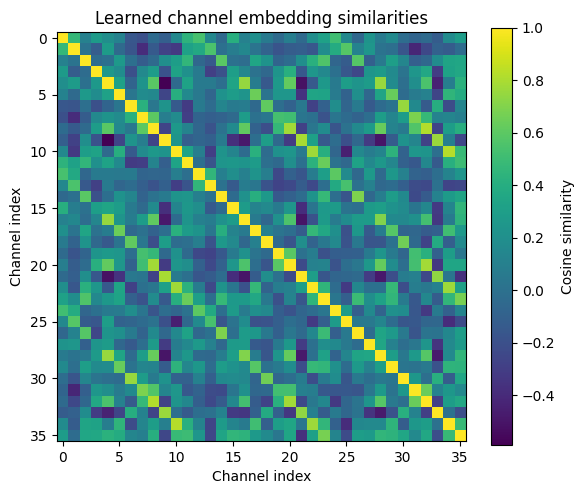

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.imshow(sim_matrix, aspect='equal')
plt.colorbar(label='Cosine similarity')
plt.xlabel('Channel index')
plt.ylabel('Channel index')
plt.title('Learned channel embedding similarities')
plt.tight_layout()
plt.show()